In [ ]:
! pwd

In [ ]:
! conda list | grep ctapipe
! conda list | grep ctlearn
! conda list | grep dl1-data-handler 
! conda list | grep tensorflow

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import ctaplot
import astropy.units as u

In [ ]:
! mkdir ../data/DL2
! mkdir ../data/DL2/runwise_files
! mkdir ../data/R1DL1_merged/test
! mkdir ../data/R1DL1_merged/test/gamma-diffuse
! mkdir ../data/R1DL1_merged/test/proton/
! cp ../data/R1DL1_merged/gamma_theta_16.087_az_108.090_runs3-4.r1.dl1.h5 ../data/R1DL1_merged/test/gamma-diffuse/
! cp ../data/R1DL1_merged/proton_theta_16.087_az_108.090_runs3-4.r1.dl1.h5 ../data/R1DL1_merged/test/proton/
! cp ../data/R1DL1_merged/proton_theta_16.087_az_108.090_runs4-6.r1.dl1.h5 ../data/R1DL1_merged/test/proton/

In [ ]:
# Predicting all files in one directory or list of absolute paths in txt
# Sims
! ctlearn --config ../configs/TRN_predicting.yml \
--tel_types LST_LST_LSTCam \
--reco type \
--output ../logs/LST1_cleanedTRN_type/ \
--mode predict \
--clean

! ctlearn --config ../configs/TRN_predicting.yml \
--tel_types LST_LST_LSTCam \
--reco energy \
--output ../logs/LST1_cleanedTRN_energy/ \
--mode predict \
--clean

! ctlearn --config ../configs/TRN_predicting.yml \
--tel_types LST_LST_LSTCam \
--reco direction \
--output ../logs/LST1_cleanedTRN_direction/ \
--mode predict \
--clean

In [ ]:
# Predicting per file
# Real data
! ctlearn -d TRN \
--input ../data/R1DL1_merged/ \
--pattern "gamma_*_runs3-4*" "proton_*_runs3-4*" "proton_*_runs5-6*" \
--tel_types LST_LST_LSTCam \
--reco type \
--output ../logs/LST1_cleanedTRN_type/ \
--prediction_directory ../data/DL2/runwise_files/ \
--mode predict \
--clean

! ctlearn -d TRN \
--input ../data/R1DL1_merged/ \
--pattern "gamma_*_runs3-4*" "proton_*_runs3-4*" "proton_*_runs5-6*" \
--tel_types LST_LST_LSTCam \
--reco energy \
--output ../logs/LST1_cleanedTRN_energy/ \
--prediction_directory ../data/DL2/runwise_files/ \
--mode predict \
--clean

! ctlearn -d TRN \
--input ../data/R1DL1_merged/ \
--pattern "gamma_*_runs3-4*" "proton_*_runs3-4*" "proton_*_runs5-6*" \
--tel_types LST_LST_LSTCam \
--reco direction \
--output ../logs/LST1_cleanedTRN_direction/ \
--prediction_directory ../data/DL2/runwise_files/ \
--mode predict \
--clean

In [ ]:
#! vitables

[]

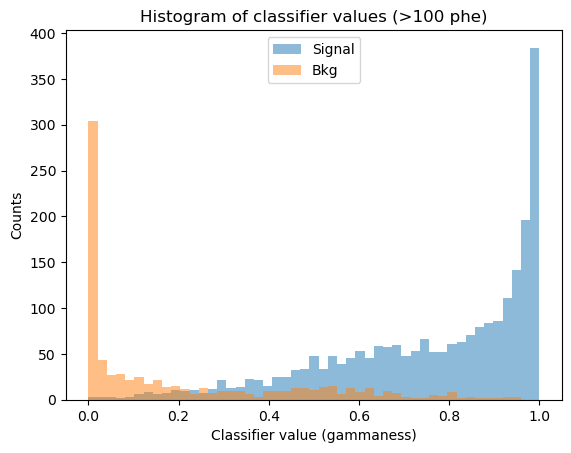

In [24]:
# Define signal and background file
column_name = "gammaness"
gamma_file = "../data/DL2/my_first_predictions_gamma-diffuse.h5"
proton_file = "../data/DL2/my_first_predictions_proton.h5"
size_cut = 100
tel_type = "LST_LST_LSTCam"

# Read data
with pd.HDFStore(gamma_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    signal_classifier_values = events_dl2[column_name][hillas_intensity > size_cut]
with pd.HDFStore(proton_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]    
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    background_classifier_values = events_dl2[column_name][hillas_intensity > size_cut]


# Make the plot
plt.figure()
bins = np.linspace(0, 1, 50)

# Plot the histograms for both classifier values
plt.hist(signal_classifier_values, bins, alpha=0.5, label='Signal')
plt.hist(background_classifier_values, bins, alpha=0.5, label='Bkg')

# Finish the plot
plt.xlabel(f'Classifier value ({column_name})')
plt.ylabel('Counts')
plt.title(f'Histogram of classifier values (>{size_cut} phe)')

plt.legend(loc='upper center')

# Show plot
plt.plot()

[]

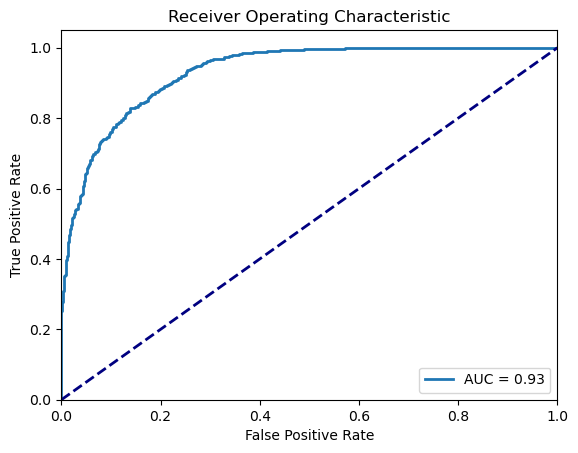

In [25]:
# Define signal and background file
column_name = "gammaness"
gamma_file = "../data/DL2/my_first_predictions_gamma-diffuse.h5"
proton_file = "../data/DL2/my_first_predictions_proton.h5"
size_cut = 100
tel_type = "LST_LST_LSTCam"

# Read data
with pd.HDFStore(gamma_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    signal_classifier_values = events_dl2[column_name][hillas_intensity > size_cut]
    signal_true_values = np.ones(len(signal_classifier_values))
with pd.HDFStore(proton_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    background_classifier_values = events_dl2[column_name][hillas_intensity > size_cut]
    background_true_values = np.zeros(len(background_classifier_values))

# Make the plot
plt.figure()

# Plot the ROC curve
classifier_values = np.concatenate((signal_classifier_values, background_classifier_values))
true_values = np.concatenate((signal_true_values, background_true_values))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_values, classifier_values)
auc = sklearn.metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label='AUC = {:.2f}'.format(auc))

# Finish the plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show plot
plt.plot()

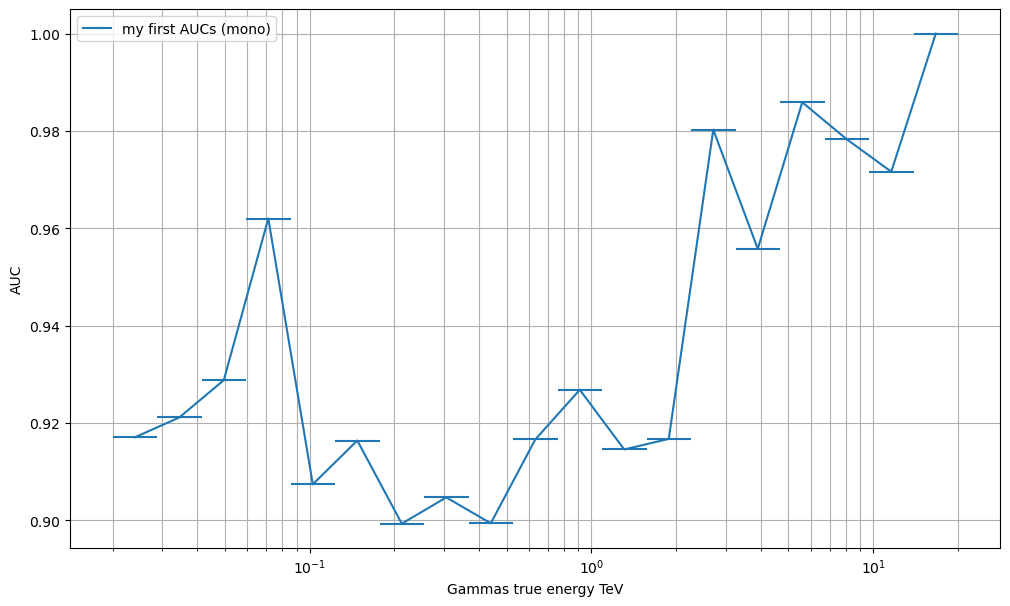

In [27]:
# Define signal and background file
column_name = "gammaness"
gamma_file = "../data/DL2/my_first_predictions_gamma-diffuse.h5"
proton_file = "../data/DL2/my_first_predictions_proton.h5"

size_cut = 100
tel_type = "LST_LST_LSTCam"

# Read data
with pd.HDFStore(gamma_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    signal_classifier_values = events_dl2[column_name][hillas_intensity > size_cut]
    signal_true_values = np.ones(len(signal_classifier_values))
    signal_true_energy = u.Quantity(events_dl2["true_energy"][hillas_intensity > size_cut], u.TeV)

with pd.HDFStore(proton_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    background_classifier_values = events_dl2[column_name][hillas_intensity > size_cut]
    background_true_values = np.zeros(len(background_classifier_values))
    background_true_energy = u.Quantity(events_dl2["true_energy"][hillas_intensity > size_cut], u.TeV)
    
energy_bins = np.logspace(np.log10(0.02), np.log10(20), 20).flatten()*u.TeV
classifier_values = np.concatenate((signal_classifier_values, background_classifier_values))
true_values = np.concatenate((signal_true_values, background_true_values))
true_energy = np.concatenate((signal_true_energy, background_true_energy))

energy_bins, auc_scores = ctaplot.roc_auc_per_energy(true_type=true_values, \
                                                     gammaness=classifier_values, \
                                                     true_energy=true_energy, \
                                                     energy_bins=energy_bins)

plt.figure(figsize=(12,7))
ax = ctaplot.plot_roc_auc_per_energy(energy_bins=energy_bins, auc_scores=auc_scores, label='my first AUCs (mono)')
ax.legend()
plt.show()


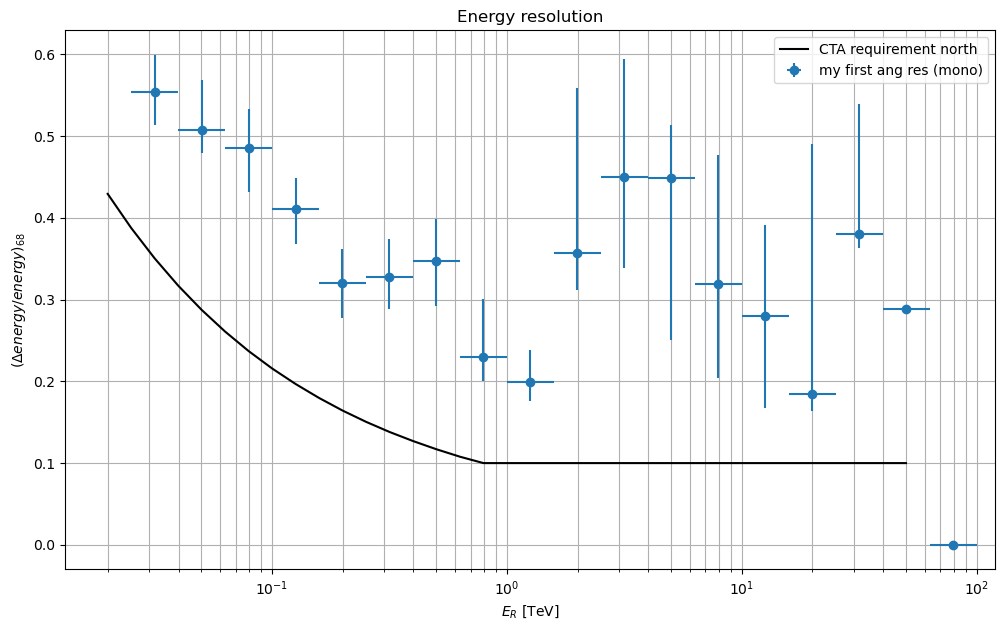

In [29]:
gamma_file = "../data/DL2/my_first_predictions_gamma-diffuse.h5"
size_cut = 50
tel_type = "LST_LST_LSTCam"

# Read data
with pd.HDFStore(gamma_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    true_energy = u.Quantity(events_dl2["true_energy"][hillas_intensity > size_cut], u.TeV)
    reco_energy = u.Quantity(events_dl2["reco_energy"][hillas_intensity > size_cut], u.TeV)
plt.figure(figsize=(12,7))
ax = ctaplot.plot_energy_resolution(true_energy, reco_energy, label="my first ang res (mono)")
ctaplot.plot_energy_resolution_cta_requirement('north', ax=ax, color='black')
ax.legend()
plt.show()

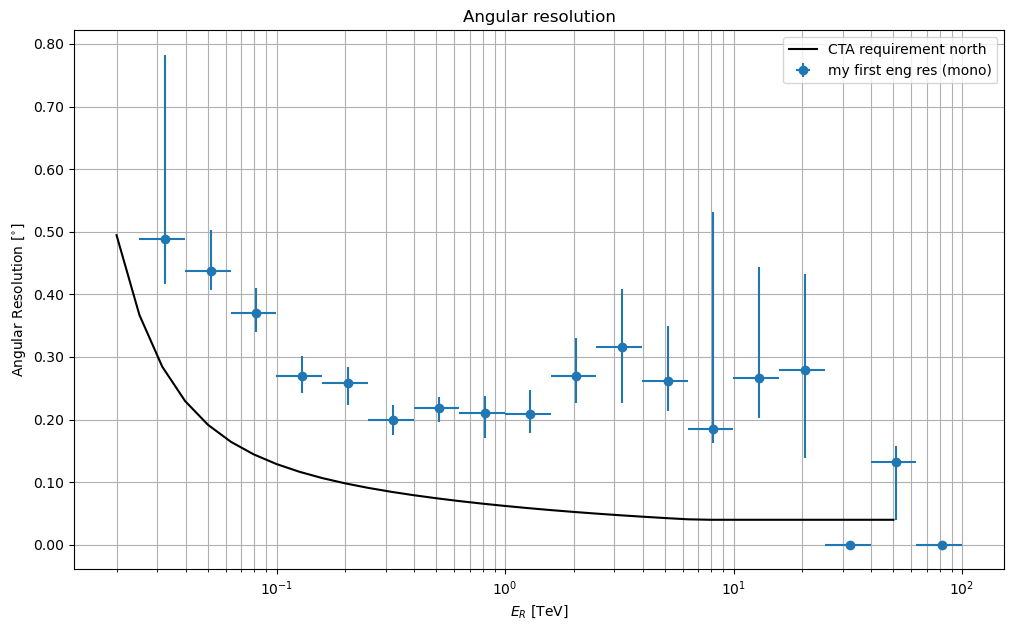

In [30]:
gamma_file = "../data/DL2/my_first_predictions_gamma-diffuse.h5"
size_cut = 100
tel_type = "LST_LST_LSTCam"

# Read data
with pd.HDFStore(gamma_file, mode="r") as f:
    events_dl2 = f["/dl2/reco"]
    events_dl1b = f[f"/dl1b/{tel_type}/tel_1"]
    hillas_intensity = events_dl1b["hillas_intensity"]
    reco_alt = u.Quantity(events_dl2["reco_alt"][hillas_intensity > size_cut], u.rad)
    reco_az = u.Quantity(events_dl2["reco_az"][hillas_intensity > size_cut], u.rad)
    source_alt = u.Quantity(events_dl2["source_alt"][hillas_intensity > size_cut], u.rad)
    source_az = u.Quantity(events_dl2["source_az"][hillas_intensity > size_cut], u.rad)
    true_energy = u.Quantity(events_dl2["true_energy"][hillas_intensity > size_cut], u.TeV)

plt.figure(figsize=(12,7))
ax = ctaplot.plot_angular_resolution_per_energy(source_alt, reco_alt, source_az, reco_az, true_energy, label="my first eng res (mono)")
ctaplot.plot_angular_resolution_cta_requirement('north', ax=ax, color='black')
plt.show()